# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
'''display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)
'''

'display = pd.read_sql_query("""\nSELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)\nFROM Reviews\nGROUP BY UserId\nHAVING COUNT(*)>1\n""", con)\n'

In [4]:
#print(display.shape)
#display.head()

In [5]:
#display[display['UserId']=='AZY10LLTJ71NX']

In [6]:
#display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
'''
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()
'''

'\ndisplay= pd.read_sql_query("""\nSELECT *\nFROM Reviews\nWHERE Score != 3 AND UserId="AR5J8UI46CURR"\nORDER BY ProductID\n""", con)\ndisplay.head()\n'

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
'''
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()
'''

'\ndisplay= pd.read_sql_query("""\nSELECT *\nFROM Reviews\nWHERE Score != 3 AND Id=44737 OR Id=64422\nORDER BY ProductID\n""", con)\n\ndisplay.head()\n'

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
'''
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)
'''

'\n# printing some random reviews\nsent_0 = final[\'Text\'].values[0]\nprint(sent_0)\nprint("="*50)\n\nsent_1000 = final[\'Text\'].values[1000]\nprint(sent_1000)\nprint("="*50)\n\nsent_1500 = final[\'Text\'].values[1500]\nprint(sent_1500)\nprint("="*50)\n\nsent_4900 = final[\'Text\'].values[4900]\nprint(sent_4900)\nprint("="*50)\n'

In [15]:
'''
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)
'''

'\n# remove urls from text python: https://stackoverflow.com/a/40823105/4084039\nsent_0 = re.sub(r"http\\S+", "", sent_0)\nsent_1000 = re.sub(r"http\\S+", "", sent_1000)\nsent_150 = re.sub(r"http\\S+", "", sent_1500)\nsent_4900 = re.sub(r"http\\S+", "", sent_4900)\n\nprint(sent_0)\n'

In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

'''
soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)
'''

'\nsoup = BeautifulSoup(sent_0, \'lxml\')\ntext = soup.get_text()\nprint(text)\nprint("="*50)\n\nsoup = BeautifulSoup(sent_1000, \'lxml\')\ntext = soup.get_text()\nprint(text)\nprint("="*50)\n\nsoup = BeautifulSoup(sent_1500, \'lxml\')\ntext = soup.get_text()\nprint(text)\nprint("="*50)\n\nsoup = BeautifulSoup(sent_4900, \'lxml\')\ntext = soup.get_text()\nprint(text)\n'

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
#sent_1500 = decontracted(sent_1500)
#print(sent_1500)
#print("="*50)

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
#sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
#print(sent_0)

In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
#sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
#print(sent_1500)

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
SORT_DATA = final.sort_values("Time")

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(SORT_DATA['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [10:51<00:00, 558.81it/s]


In [24]:
SORT_DATA['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [25]:
DATA = np.array(preprocessed_reviews[0:50000])
LABEL  = np.array(SORT_DATA['Score'][0:50000])

In [26]:
from sklearn.model_selection import train_test_split
X_train_temp, X_TEST, Y_train_temp, Y_TEST = train_test_split(DATA, LABEL, test_size=0.33,stratify=LABEL)
X_TRAIN, X_CV, Y_TRAIN, Y_CV = train_test_split(X_train_temp, Y_train_temp, test_size=0.33,stratify=Y_train_temp)

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

In [67]:
def RF(X_train,Y_TRAIN,X_cv,Y_CV,X_test,Y_TEST):
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_auc_score
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    
    scalar = StandardScaler(with_mean=False)
    X_TRAIN = scalar.fit_transform(X_train)
    X_TEST= scalar.transform(X_test)
    X_CV=scalar.transform(X_cv)
    
    DEPTHS = [20,40,60,80,100,120]
    BASE_LEARNERS=[1,5,10,50,100,500,1000]
    AUC_CV=[]
    AUC_TRAIN=[]
    
    for BL in BASE_LEARNERS:
        for D  in DEPTHS:
            RF = RandomForestClassifier(max_features='sqrt',max_depth=D,n_estimators=BL)
            RF.fit(X_TRAIN,Y_TRAIN)
            PROB_CV = RF.predict_proba(X_CV)
            PROB_TRAIN = RF.predict_proba(X_TRAIN)
            PROB_CV = PROB_CV[:,1]
            PROB_TRAIN = PROB_TRAIN[:,1]
            auc_score_cv = roc_auc_score(Y_CV,PROB_CV)
            auc_score_train = roc_auc_score(Y_TRAIN,PROB_TRAIN)
            AUC_CV.append(auc_score_cv)
            AUC_TRAIN.append(auc_score_train)
            
    print("="*30, "AUC Score for train data", "="*30)
    AUC_TRAIN = np.array(AUC_TRAIN).reshape(7,6)
    plt.figure(figsize=(10,5))
    sns.heatmap(AUC_TRAIN,annot=True, xticklabels=DEPTHS,yticklabels=BASE_LEARNERS)
    plt.xlabel('DEPTHS')
    plt.ylabel('BASE_LEARNERS')
    plt.show()
    
    print("="*30, "AUC Score for CV DATA", "="*30)
    AUC_CV = np.array(AUC_CV).reshape(7,6)
    plt.figure(figsize=(10,5))
    sns.heatmap(AUC_CV,annot=True, xticklabels=DEPTHS,yticklabels=BASE_LEARNERS)
    plt.xlabel('DEPTHS')
    plt.ylabel('BASE_LEARNERS')
    plt.show()


In [68]:
def RF_TESTING(X_train,Y_TRAIN,X_cv,Y_CV,X_test,Y_TEST,optimal_depth,optimal_base_learner):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import roc_auc_score
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    
    scalar = StandardScaler(with_mean=False)
    X_TRAIN = scalar.fit_transform(X_train)
    X_TEST= scalar.transform(X_test)
    X_CV=scalar.transform(X_cv)
    
    RF = RandomForestClassifier(max_features='sqrt',max_depth=optimal_depth,n_estimators=optimal_base_learner)
    RF.fit(X_TRAIN,Y_TRAIN)
    
    
    TRAIN_PROBA=  list(RF.predict_proba(X_TRAIN)[:,1])
    TEST_PROBA =  list(RF.predict_proba(X_TEST)[:,1])
    
    from sklearn import metrics
    fpr_2,tpr_2,tr_2 = metrics.roc_curve(Y_TEST,TEST_PROBA)
    fpr_1,tpr_1,tr_1 = metrics.roc_curve(Y_TRAIN,TRAIN_PROBA)
    lw=2
    area_train = metrics.auc(fpr_1, tpr_1)
    area_test = metrics.auc(fpr_2, tpr_2)
    plt.plot(fpr_2, tpr_2, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
    plt.plot(fpr_1, tpr_1, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
    plt.legend()
    plt.title("ROC CURVE")
    
    PRED_TEST=list(RF.predict(X_TEST))
    PRED_TEST = np.array(PRED_TEST)

   
    PRED_TRAIN=list(RF.predict(X_TRAIN))
    PRED_TRAIN = np.array(PRED_TRAIN)
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    plt.figure()
    cm = confusion_matrix(Y_TEST,PRED_TEST)
    class_label = ["negative", "positive"]
    df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm_test , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    plt.figure()
    cm = confusion_matrix(Y_TRAIN,PRED_TRAIN)
    class_label = ["negative", "positive"]
    df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm_test , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for train data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    

# BOW

In [30]:
#.....CONVERT it into BOW VECTORS....
from sklearn.feature_extraction.text import CountVectorizer
OBJ_BOW = CountVectorizer()
OBJ_BOW.fit(X_TRAIN)




X_TRAIN_BOW =OBJ_BOW.transform(X_TRAIN)
X_CV_BOW = OBJ_BOW.transform(X_CV)
X_TEST_BOW = OBJ_BOW.transform(X_TEST)




print("After vectorizations")
print(X_TRAIN_BOW.shape, Y_TRAIN.shape)
print(X_CV_BOW.shape,Y_CV.shape)
print(X_TEST_BOW.shape, Y_TEST.shape)
print("="*100)

After vectorizations
(22445, 29062) (22445,)
(11055, 29062) (11055,)
(16500, 29062) (16500,)


### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


============================== AUC Score for train data ==============================


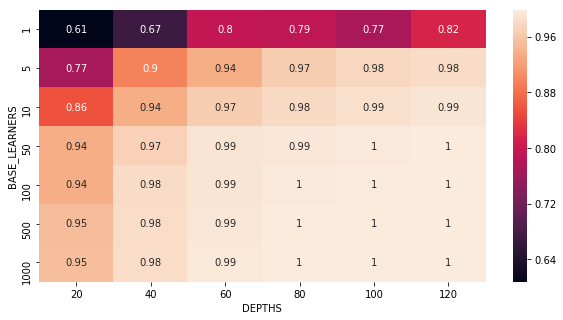

============================== AUC Score for CV DATA ==============================


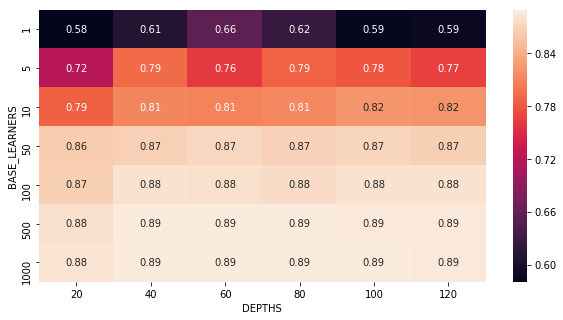

In [50]:
# Please write all the code with proper documentation
RF(X_TRAIN_BOW,Y_TRAIN,X_CV_BOW,Y_CV,X_TEST_BOW,Y_TEST)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


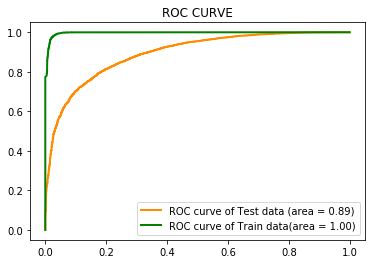

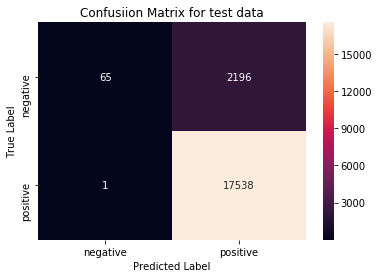

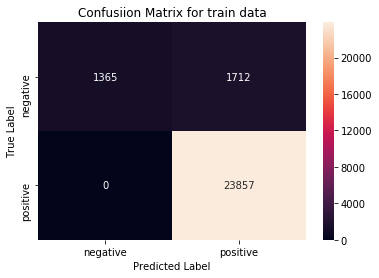

In [54]:
RF_TESTING(X_TRAIN_BOW,Y_TRAIN,X_CV_BOW,Y_CV,X_TEST_BOW,Y_TEST,80,500)

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


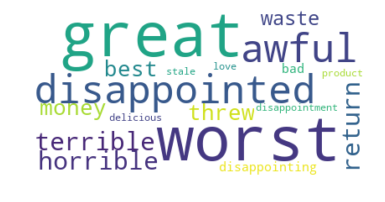

In [55]:

# Please write all the code with proper documentation
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
scalar = StandardScaler(with_mean=False)
X_TRAIN = scalar.fit_transform(X_TRAIN_BOW)
X_TEST= scalar.transform(X_TEST_BOW)
X_CV=scalar.transform(X_CV_BOW)
RF = RandomForestClassifier(max_features='sqrt',max_depth=80,n_estimators=500)
RF.fit(X_TRAIN,Y_TRAIN)
    
FEATURES = OBJ_BOW.get_feature_names()
data=''
feat=RF.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:20]:
    data+=FEATURES[i]
    data+=' '
    
    
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# TFIDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
VECTORIZER_TF_IDF = TfidfVectorizer(ngram_range=(1,2), min_df=10)
VECTORIZER_TF_IDF.fit(X_TRAIN)


X_TRAIN_TFIDF = VECTORIZER_TF_IDF.transform(X_TRAIN)
X_CV_TFIDF = VECTORIZER_TF_IDF.transform(X_CV)
X_TEST_TFIDF = VECTORIZER_TF_IDF.transform(X_TEST)



print("After vectorizations")
print(X_TRAIN_TFIDF.shape, Y_TRAIN.shape)
print(X_CV_TFIDF.shape,Y_CV.shape)
print(X_TEST_TFIDF.shape, Y_TEST.shape)
print("="*100)



After vectorizations
(22445, 12595) (22445,)
(11055, 12595) (11055,)
(16500, 12595) (16500,)


### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

============================== AUC Score for train data ==============================


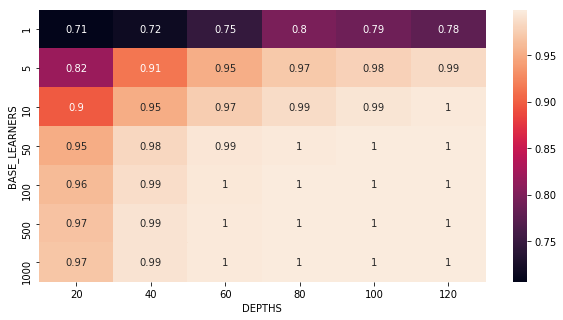

============================== AUC Score for CV DATA ==============================


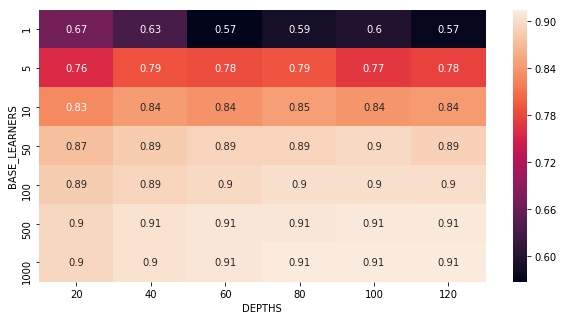

In [60]:
# Please write all the code with proper documentation
RF(X_TRAIN_TFIDF,Y_TRAIN,X_CV_TFIDF,Y_CV,X_TEST_TFIDF,Y_TEST)

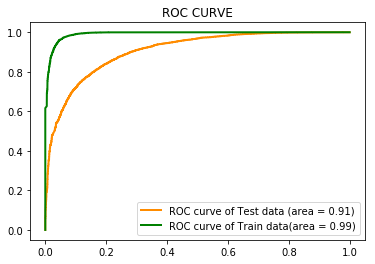

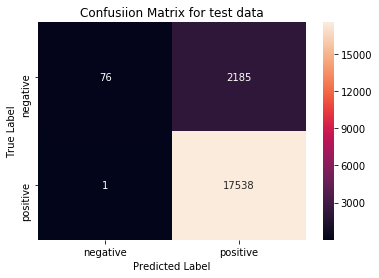

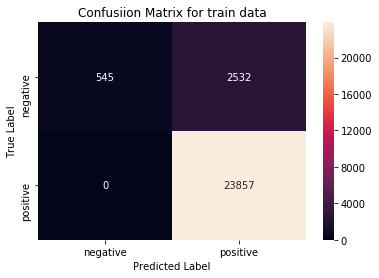

In [64]:
RF_TESTING(X_TRAIN_TFIDF,Y_TRAIN,X_CV_TFIDF,Y_CV,X_TEST_TFIDF,Y_TEST,40,500)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

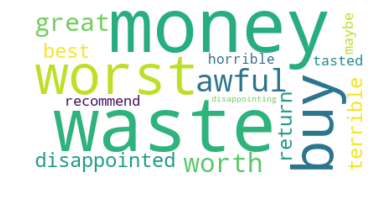

In [65]:

# Please write all the code with proper documentation
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
scalar = StandardScaler(with_mean=False)
X_TRAIN = scalar.fit_transform(X_TRAIN_TFIDF)
X_TEST= scalar.transform(X_TEST_TFIDF)
X_CV=scalar.transform(X_CV_TFIDF)
RF = RandomForestClassifier(max_features='sqrt',max_depth=40,n_estimators=50)
RF.fit(X_TRAIN,Y_TRAIN)
    
FEATURES = VECTORIZER_TF_IDF.get_feature_names()
data=''
feat=RF.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:20]:
    data+=FEATURES[i]
    data+=' '
    
    
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# AVG W2V

In [32]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_TRAIN:
    list_of_sentance.append(sentance.split())

 # min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


number of words that occured minimum 5 times  9103


In [33]:
def AVGW2V(X_test):
   
    i=0
    list_of_sentance=[]
    for sentance in X_test:
        list_of_sentance.append(sentance.split())
    test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        test_vectors.append(sent_vec)
    return test_vectors

In [34]:
AV_TRAIN_BOW = AVGW2V(X_TRAIN)
AV_CV_BOW = AVGW2V(X_CV)
AV_TEST_BOW = AVGW2V(X_TEST)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16500/16500 [01:40<00:00, 163.42it/s]


### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

============================== AUC Score for train data ==============================


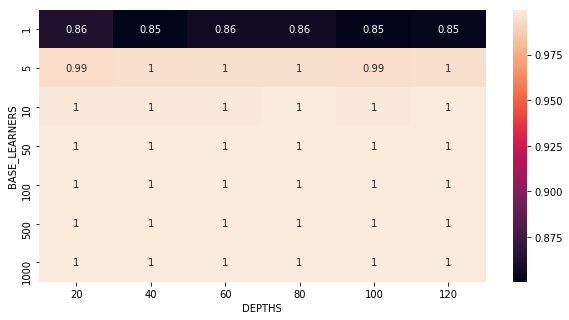

============================== AUC Score for CV DATA ==============================


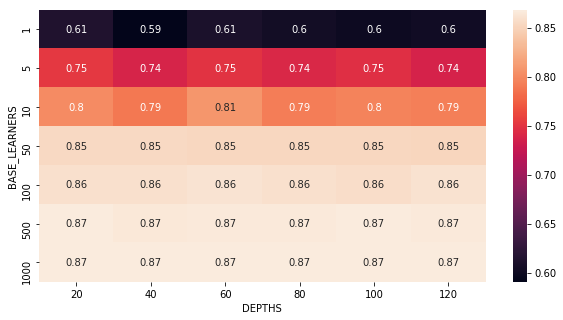

In [69]:
# Please write all the code with proper documentation
RF(AV_TRAIN_BOW,Y_TRAIN,AV_CV_BOW,Y_CV,AV_TEST_BOW,Y_TEST)

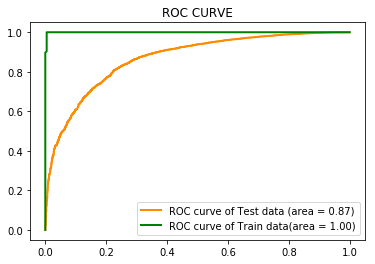

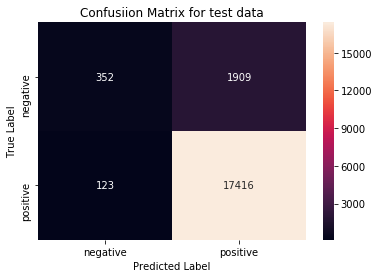

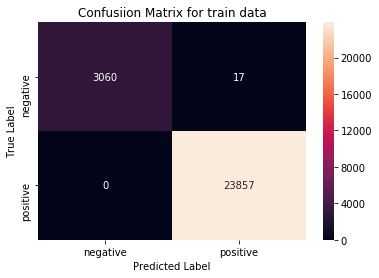

In [70]:
RF_TESTING(AV_TRAIN_BOW,Y_TRAIN,AV_CV_BOW,Y_CV,AV_TEST_BOW,Y_TEST,20,500)

# TFIDF W2V

In [35]:

model = TfidfVectorizer()
model.fit(X_TRAIN)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf



In [36]:



def TFIDFW2V(test):
    '''
    Returns tfidf word2vec
    '''
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    i=0
    list_of_sentance=[]
    for sentance in test:
        list_of_sentance.append(sentance.split())
        
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
     
    return tfidf_sent_vectors
      

In [37]:
AV_TRAIN_TFIDF = TFIDFW2V(X_TRAIN)
AV_CV_TFIDF = TFIDFW2V(X_CV)
AV_TEST_TFIDF = TFIDFW2V(X_TEST)  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16500/16500 [13:42<00:00, 20.06it/s]


### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

============================== AUC Score for train data ==============================


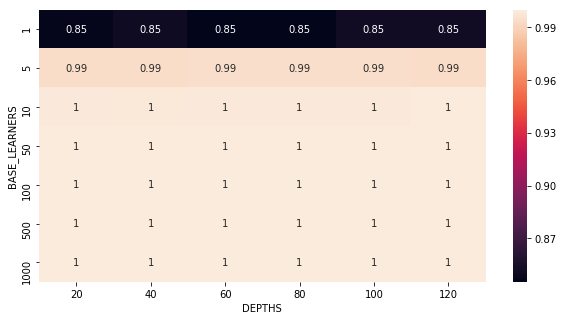

============================== AUC Score for CV DATA ==============================


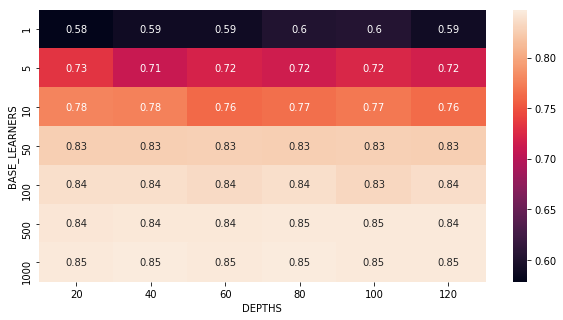

In [71]:
# Please write all the code with proper documentation
RF(AV_TRAIN_TFIDF,Y_TRAIN,AV_CV_TFIDF,Y_CV,AV_TEST_TFIDF,Y_TEST)

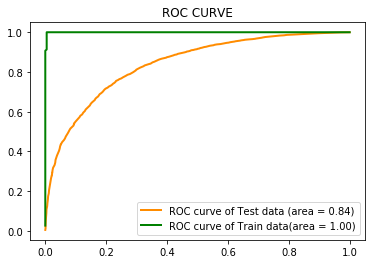

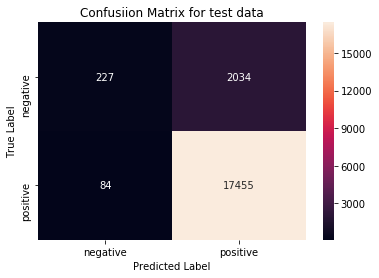

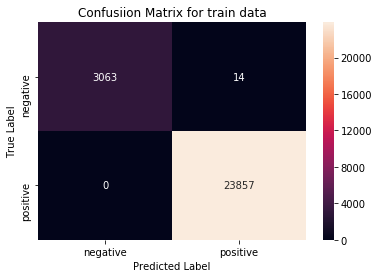

In [72]:
RF_TESTING(AV_TRAIN_TFIDF,Y_TRAIN,AV_CV_TFIDF,Y_CV,AV_TEST_TFIDF,Y_TEST,80,500)

## [5.2] Applying GBDT using XGBOOST

In [38]:
def XGBOOST(X_train,Y_TRAIN,X_cv,Y_CV,X_test,Y_TEST):
    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    
    scalar = StandardScaler(with_mean=False)
    X_TRAIN = scalar.fit_transform(X_train)
    X_TEST= scalar.transform(X_test)
    X_CV=scalar.transform(X_cv)
    
    DEPTHS = [20,40,60,80,100,120]
    BASE_LEARNERS=[1,5,10,50,100,500,1000]
    AUC_CV=[]
    AUC_TRAIN=[]
    
    for BL in BASE_LEARNERS:
        for D  in DEPTHS:
            GBDT=XGBClassifier(booster='gbtree' ,max_depth=D,n_estimators=BL)
            GBDT.fit(X_TRAIN,Y_TRAIN)
            PROB_CV = GBDT.predict_proba(X_CV)
            PROB_TRAIN = GBDT.predict_proba(X_TRAIN)
            PROB_CV = PROB_CV[:,1]
            PROB_TRAIN = PROB_TRAIN[:,1]
            auc_score_cv = roc_auc_score(Y_CV,PROB_CV)
            auc_score_train = roc_auc_score(Y_TRAIN,PROB_TRAIN)
            AUC_CV.append(auc_score_cv)
            AUC_TRAIN.append(auc_score_train)
            
    print("="*30, "AUC Score for train data", "="*30)
    AUC_TRAIN = np.array(AUC_TRAIN).reshape(7,6)
    plt.figure(figsize=(10,5))
    sns.heatmap(AUC_TRAIN,annot=True, xticklabels=DEPTHS,yticklabels=BASE_LEARNERS)
    plt.xlabel('DEPTHS')
    plt.ylabel('BASE_LEARNERS')
    plt.show()
    
    print("="*30, "AUC Score for CV DATA", "="*30)
    AUC_CV = np.array(AUC_CV).reshape(7,6)
    plt.figure(figsize=(10,5))
    sns.heatmap(AUC_CV,annot=True, xticklabels=DEPTHS,yticklabels=BASE_LEARNERS)
    plt.xlabel('DEPTHS')
    plt.ylabel('BASE_LEARNERS')
    plt.show()


In [39]:
def XGBOOST_TESTING(X_train,Y_TRAIN,X_cv,Y_CV,X_test,Y_TEST,optimal_depth,optimal_base_learner):
    from xgboost import XGBClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import roc_auc_score
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    
    scalar = StandardScaler(with_mean=False)
    X_TRAIN = scalar.fit_transform(X_train)
    X_TEST= scalar.transform(X_test)
    X_CV=scalar.transform(X_cv)
    
    GBDT=XGBClassifier(booster='gbtree' ,max_depth=optimal_depth,n_estimators=optimal_base_learner)
    GBDT.fit(X_TRAIN,Y_TRAIN)
    
    
    TRAIN_PROBA=  list(GBDT.predict_proba(X_TRAIN)[:,1])
    TEST_PROBA =  list(GBDT.predict_proba(X_TEST)[:,1])
    
    from sklearn import metrics
    fpr_2,tpr_2,tr_2 = metrics.roc_curve(Y_TEST,TEST_PROBA)
    fpr_1,tpr_1,tr_1 = metrics.roc_curve(Y_TRAIN,TRAIN_PROBA)
    lw=2
    area_train = metrics.auc(fpr_1, tpr_1)
    area_test = metrics.auc(fpr_2, tpr_2)
    plt.plot(fpr_2, tpr_2, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
    plt.plot(fpr_1, tpr_1, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
    plt.legend()
    plt.title("ROC CURVE")
    
    PRED_TEST=list(GBDT.predict(X_TEST))
    PRED_TEST = np.array(PRED_TEST)

   
    PRED_TRAIN=list(GBDT.predict(X_TRAIN))
    PRED_TRAIN = np.array(PRED_TRAIN)
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    plt.figure()
    cm = confusion_matrix(Y_TEST,PRED_TEST)
    class_label = ["negative", "positive"]
    df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm_test , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for test data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    plt.figure()
    cm = confusion_matrix(Y_TRAIN,PRED_TRAIN)
    class_label = ["negative", "positive"]
    df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm_test , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for train data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


============================== AUC Score for train data ==============================


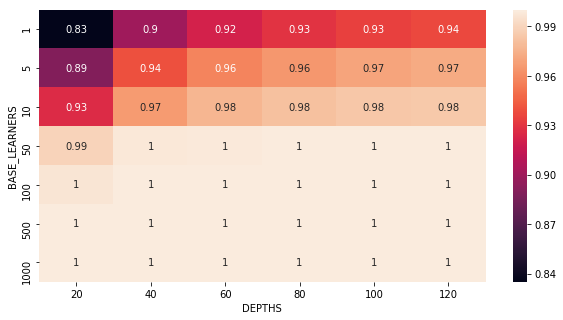

============================== AUC Score for CV DATA ==============================


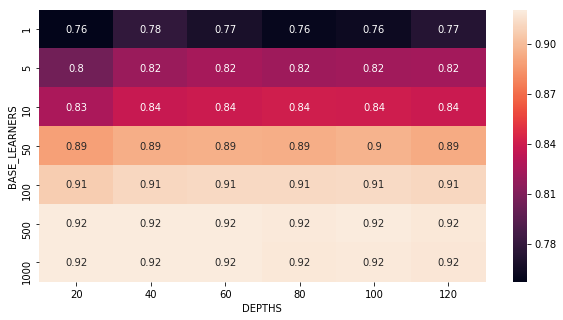

In [40]:
# Please write all the code with proper documentation
XGBOOST(X_TRAIN_BOW,Y_TRAIN,X_CV_BOW,Y_CV,X_TEST_BOW,Y_TEST)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambi

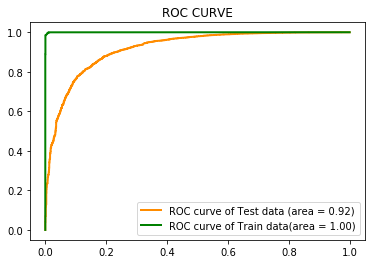

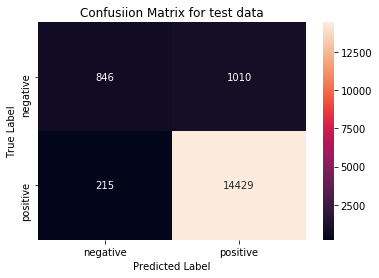

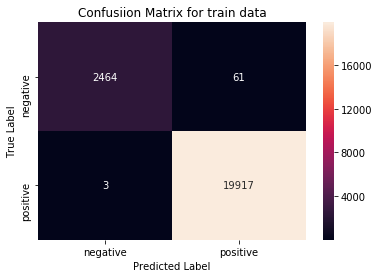

In [48]:
# Please write all the code with proper documentation
XGBOOST_TESTING(X_TRAIN_BOW,Y_TRAIN,X_CV_BOW,Y_CV,X_TEST_BOW,Y_TEST,20,500)

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

============================== AUC Score for train data ==============================


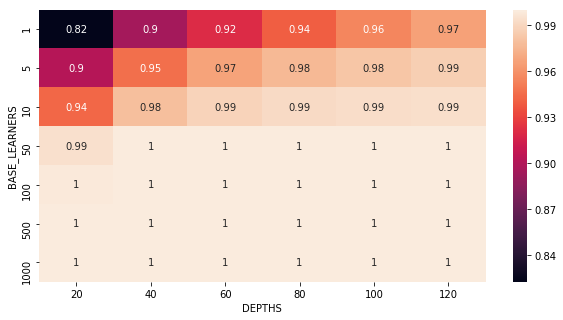

============================== AUC Score for CV DATA ==============================


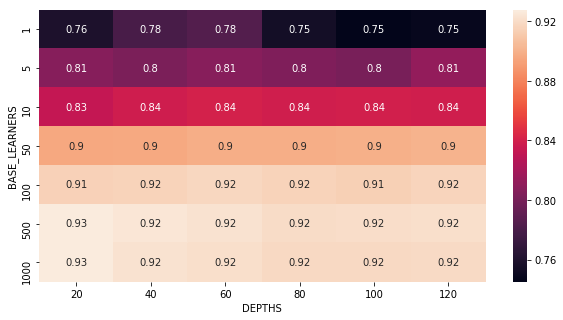

In [42]:
# Please write all the code with proper documentation
XGBOOST(X_TRAIN_TFIDF,Y_TRAIN,X_CV_TFIDF,Y_CV,X_TEST_TFIDF,Y_TEST)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


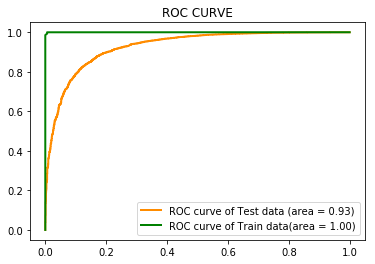

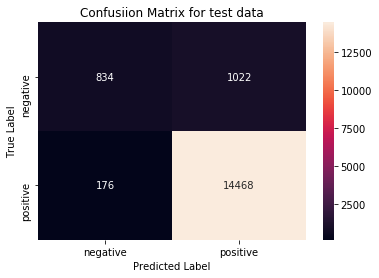

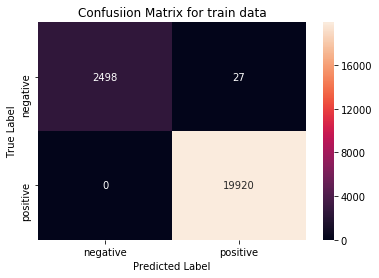

In [49]:
# Please write all the code with proper documentation
XGBOOST_TESTING(X_TRAIN_TFIDF,Y_TRAIN,X_CV_TFIDF,Y_CV,X_TEST_TFIDF,Y_TEST,20,500)

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

============================== AUC Score for train data ==============================


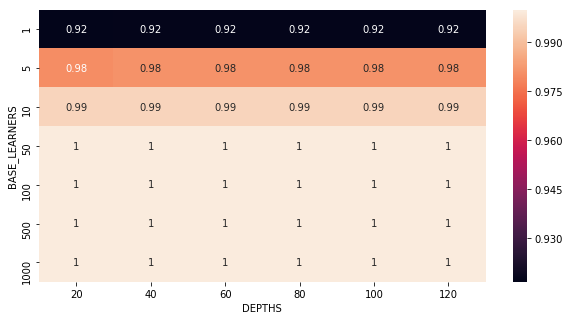

============================== AUC Score for CV DATA ==============================


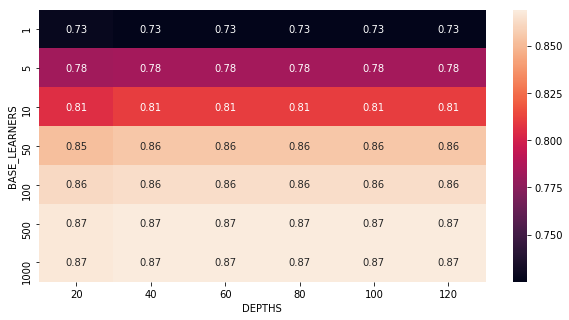

In [44]:
# Please write all the code with proper documentation
XGBOOST(AV_TRAIN_BOW,Y_TRAIN,AV_CV_BOW,Y_CV,AV_TEST_BOW,Y_TEST)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


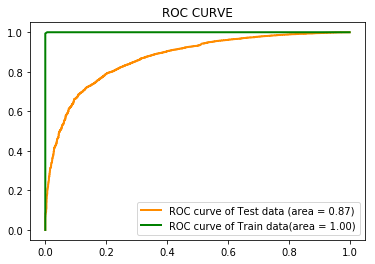

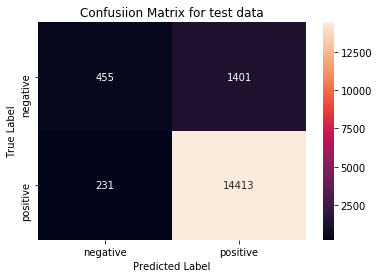

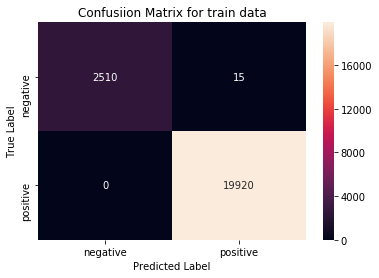

In [50]:
# Please write all the code with proper documentation
XGBOOST_TESTING(AV_TRAIN_BOW,Y_TRAIN,AV_CV_BOW,Y_CV,AV_TEST_BOW,Y_TEST,40,500)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

============================== AUC Score for train data ==============================


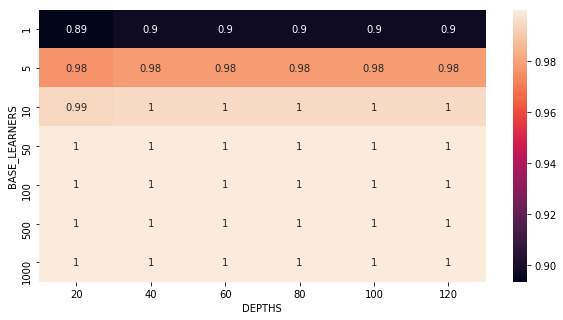

============================== AUC Score for CV DATA ==============================


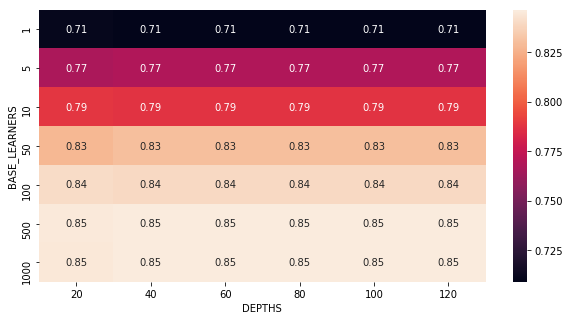

In [46]:
# Please write all the code with proper documentation
XGBOOST(AV_TRAIN_TFIDF,Y_TRAIN,AV_CV_TFIDF,Y_CV,AV_TEST_TFIDF,Y_TEST)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


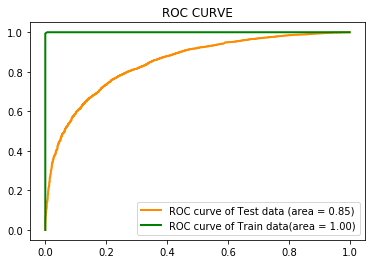

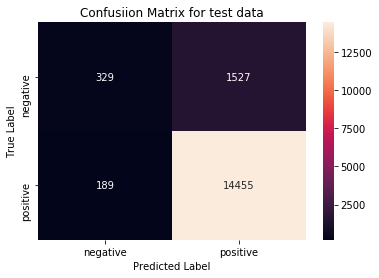

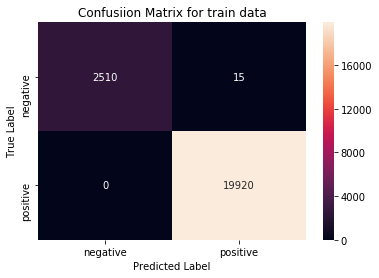

In [51]:
# Please write all the code with proper documentation
XGBOOST_TESTING(AV_TRAIN_TFIDF,Y_TRAIN,AV_CV_TFIDF,Y_CV,AV_TEST_TFIDF,Y_TEST,40,500)

# [6] Conclusions

In [52]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
X = PrettyTable()
print(" "*40+"CONCLUSION")
print("="*100)


X.field_names = ["METHOD","VECTORIZER", "MAX_DEPTH", "NUMBER OF ESTIMATOR","TEST_AUC"]
X.add_row(["RF","BOW",80,500,0.89])
X.add_row(["RF","TFIDF",40,500,0.91])
X.add_row(["RF","AVGW2V",20,500,0.87])
X.add_row(["RF","TFIDFW2V",80,500,0.84])

X.add_row(["XBOOST","BOW",20,500,0.92])
X.add_row(["XBOOST","TFIDF",20,500,0.93])
X.add_row(["XBOOST","AVGW2V",40,500,0.87])
X.add_row(["XBOOST","TFIDFW2V",40,500,0.85])


print(X)

                                        CONCLUSION
+--------+------------+-----------+---------------------+----------+
| METHOD | VECTORIZER | MAX_DEPTH | NUMBER OF ESTIMATOR | TEST_AUC |
+--------+------------+-----------+---------------------+----------+
|   RF   |    BOW     |     80    |         500         |   0.89   |
|   RF   |   TFIDF    |     40    |         500         |   0.91   |
|   RF   |   AVGW2V   |     20    |         500         |   0.87   |
|   RF   |  TFIDFW2V  |     80    |         500         |   0.84   |
| XBOOST |    BOW     |     20    |         500         |   0.92   |
| XBOOST |   TFIDF    |     20    |         500         |   0.93   |
| XBOOST |   AVGW2V   |     40    |         500         |   0.87   |
| XBOOST |  TFIDFW2V  |     40    |         500         |   0.85   |
+--------+------------+-----------+---------------------+----------+


REFRENCE:https://github.com/krpiyush5/Amazon-Fine-Food-Review/blob/master/XGBOOST%20GBDT%20on%20amazon%20fine%20food%20review/Amazon%20Fine%20Food%20Reviews%20Analysis_GBDT.ipynb

# I have completed this assingment by taking 60K points